In [1]:
!pip install psycopg2-binary pandas sqlalchemy matplotlib numpy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\626\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import psycopg2
from psycopg2 import Error
from psycopg2 import extras # For execute_values
import pandas as pd
from sqlalchemy import create_engine
import io # For StringIO
import time
import matplotlib.pyplot as plt
import numpy as np
import os # To check file existence

In [3]:
small_csv_path = r'"C:\Users\626\Downloads\upload_test_data.csv"'

In [4]:
big_csv_path = r'"C:\Users\626\Downloads\upload_test_data_big.csv"'

In [5]:
!ls

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [6]:
# @markdown Установка и импорт необходимых библиотек.


print("Libraries installed and imported successfully.")

# Database connection details (replace with your actual credentials if different)
DB_USER = "postgres"
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "lect_08_bda_big_data"

# CSV File Paths (Ensure these files are uploaded to your Colab environment)
small_csv_path = 'upload_test_data.csv'
big_csv_path = 'upload_test_data_big.csv' # Corrected filename

# Table name in PostgreSQL
table_name = 'sales_data'

Libraries installed and imported successfully.


In [7]:
# @title # 3. Database Connection Test
# @markdown Проверка соединения с базой данных PostgreSQL.

connection = None
cursor = None
engine = None # For pandas.to_sql

try:
    # Establish connection using psycopg2
    print("Connecting to PostgreSQL database using psycopg2...")
    connection = psycopg2.connect(user=DB_USER,
                                  password=DB_PASSWORD,
                                  host=DB_HOST,
                                  port=DB_PORT,
                                  database=DB_NAME)
    connection.autocommit = False # Important for COPY and batch inserts within transactions
    cursor = connection.cursor()

    print("PostgreSQL server information:")
    print(connection.get_dsn_parameters(), "\n")
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print(f"Successfully connected to: {record[0]}\n")

    # Create SQLAlchemy engine for pandas
    print("Creating SQLAlchemy engine...")
    engine_url = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    engine = create_engine(engine_url)
    print("SQLAlchemy engine created successfully.")


except (Exception, Error) as error:
    print(f"Error while connecting to PostgreSQL: {error}")
    # Ensure resources are closed even if connection fails partially
    if cursor:
        cursor.close()
    if connection:
        connection.close()
    if engine:
        engine.dispose() # Close SQLAlchemy engine pool
    connection, cursor, engine = None, None, None # Reset variables

# We keep the connection open for the rest of the script.
# It will be closed in the final step.

Connecting to PostgreSQL database using psycopg2...
PostgreSQL server information:
{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'lect_08_bda_big_data', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslcertmode': 'allow', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'gssdelegation': '0', 'target_session_attrs': 'any', 'load_balance_hosts': 'disable'} 

Successfully connected to: PostgreSQL 16.8, compiled by Visual C++ build 1942, 64-bit

Creating SQLAlchemy engine...
SQLAlchemy engine created successfully.


In [8]:
# @title Вспомогательные Функции (Часть Базового Кода)
# Убедитесь, что эта ячейка выполняется ПЕРЕД запуском кода варианта

# ... (здесь должны быть определения connect_db, close_db, execute_sql, load_df_from_sql и т.д.)

def execute_sql(sql_query, fetch=False):
    """Выполняет SQL-запрос и опционально возвращает результаты."""
    if not connection or not cursor:
        print("Нет подключения к БД.")
        return None
    try:
        # print(f"Выполнение SQL: {sql_query[:100]}...") # Отладка: показать начало запроса
        cursor.execute(sql_query)
        if fetch:
            results = cursor.fetchall()
            # print("Результаты получены.") # Отладка
            return results
        else:
            # Для запросов не SELECT (CREATE, DROP, INSERT, UPDATE, DELETE)
            # connection.commit() # Не требуется при autocommit=True
            # print("Запрос успешно выполнен (без fetch).") # Отладка
            return True # Возвращаем True для индикации успеха выполнения не-SELECT запроса
    except (Exception, Error) as error:
        print(f"Ошибка выполнения SQL: {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return None # Возвращаем None для индикации ошибки

# --- Функция создания таблицы ---
def create_table(tbl_name):
    """Создает стандартную таблицу для данных продаж, удаляя ее, если она существует."""
    print(f"\nПопытка создать таблицу: {tbl_name}")
    # Шаг 1: Удалить таблицу, если она уже существует
    # Это важно для повторяемости: гарантирует, что мы начинаем с чистого листа
    # и не получим ошибку "table already exists".
    drop_success = execute_sql(f"DROP TABLE IF EXISTS {tbl_name};")
    if drop_success is None: # Проверяем, не было ли ошибки при DROP
        print(f"Не удалось выполнить DROP TABLE для {tbl_name}. Создание таблицы отменено.")
        return # Прерываем создание, если DROP не удался

    # Шаг 2: Определить SQL-запрос для создания таблицы
    # Структура таблицы (колонки и типы данных) соответствует анализу
    # из исходной практической работы. Имя таблицы берется из аргумента tbl_name.
    create_query = f"""
    CREATE TABLE {tbl_name} (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    """
    print(f"Запрос на создание таблицы {tbl_name}:\n{create_query}")

    # Шаг 3: Выполнить SQL-запрос на создание таблицы
    create_success = execute_sql(create_query)
    if create_success:
        print(f"Таблица '{tbl_name}' успешно создана.")
    else:
        print(f"Не удалось создать таблицу '{tbl_name}'.")

# ... (здесь определения load_via_pandas, load_via_copy_file, load_via_copy_stringio и т.д.)


# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, load_df_from_sql, create_table) ...

# --- Функции Загрузки Данных ---

def load_via_copy_file(file_path, tbl_name):
    """Загружает данные из DataFrame через file, используя copy_expert."""
    # Проверка подключения и наличия данных
    if not connection or not cursor:
        print("Нет подключения к БД или DataFrame пуст.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file)...")
    start_time = time.time()
    buffer = io.StringIO() # Создаем буфер в памяти

    # Записываем DataFrame в буфер как CSV, включая заголовок
    try:
        df.to_csv(buffer, index=False, header=True, sep=',')
    except Exception as e:
         print(f"Ошибка конвертации DataFrame в CSV: {e}")
         buffer.close() # Закрываем буфер при ошибке
         return False # Возвращаем False при неудаче
    buffer.seek(0) # Перематываем буфер в начало для чтения
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Выполняем COPY, передавая буфер как файл
        cursor.copy_expert(sql=sql_copy, file=buffer)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче
    finally:
        buffer.close() # Гарантируем закрытие буфера в любом случае


In [9]:
def load_via_copy_file(file_path, tbl_name):
    """Загружает данные напрямую из CSV файла, используя copy_expert."""
    # Проверка подключения
    if not connection or not cursor:
       print("Нет подключения к БД.")
       return False # Возвращаем False при неудаче
    # Проверка существования файла
    if not os.path.exists(file_path):
        print(f"ОШИБКА: Файл '{file_path}' не найден.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file: {os.path.basename(file_path)})...")
    start_time = time.time()
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Открываем файл для чтения и передаем его дескриптор в copy_expert
        with open(file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql=sql_copy, file=f)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче

# ... (другие вспомогательные функции, если есть) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


In [10]:
# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, create_table, ...) ...

# --- Функция загрузки данных из SQL в DataFrame ---
def load_df_from_sql(sql_query):
    """Выполняет SQL-запрос и загружает результаты в Pandas DataFrame."""
    # Проверяем наличие активного подключения
    if not connection: # Для read_sql_query достаточно объекта connection
        print("Нет подключения к БД для загрузки DataFrame.")
        return None # Возвращаем None при ошибке
    print(f"Загрузка данных из SQL в DataFrame: {sql_query[:100]}...") # Показываем начало запроса
    try:
        # Используем pandas.read_sql_query для выполнения запроса и создания DataFrame
        # Эта функция сама управляет курсором и соединением для чтения
        df = pd.read_sql_query(sql_query, connection)
        print(f"Успешно: Загружено {len(df)} строк в DataFrame.")
        return df # Возвращаем созданный DataFrame
    except (Exception, Error) as error:
        # Обрабатываем ошибки при выполнении запроса или создании DataFrame
        print(f"ОШИБКА при загрузке DataFrame из SQL: {error}")
        return None # Возвращаем None при ошибке

# ... (определения load_via_copy_stringio, load_via_copy_file и другие функции) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


In [11]:
# -*- coding: utf-8 -*-
"""
Мини-проект: Решение для Варианта 8
"""

# @title Настройка окружения и подключение к БД (Запустить первым - Базовый код)
# ... (здесь должен быть весь ваш базовый код с импортами, константами, функциями)
# Убедитесь, что функции connect_db, create_table, execute_sql, load_df_from_sql,
# load_via_copy_stringio, load_via_copy_file определены и выполнены.
# ...

# --- Константы для этого варианта ---
small_table_name = 'sales_small'
big_table_name = 'sales_big'
small_csv_path = r"C:\Users\626\Downloads\upload_test_data.csv"
big_csv_path = r"C:\Users\626\Downloads\upload_test_data_big.csv"
# ----------------------------------


# Проверяем статус подключения перед продолжением
if not connection or not cursor:
    print("Подключение к базе данных неактивно. Пожалуйста, выполните настройку подключения.")
else:
    print("--- Запуск Варианта 8 (Упрощенная загрузка) ---")

    # --- Задача 1: Настройка таблиц ---
    print("\n--- Задача 1: Создание таблиц ---")
    create_table(small_table_name)
    create_table(big_table_name)
    # Функция create_table должна вывести сообщения об успехе/ошибке

--- Запуск Варианта 8 (Упрощенная загрузка) ---

--- Задача 1: Создание таблиц ---

Попытка создать таблицу: sales_small
Запрос на создание таблицы sales_small:

    CREATE TABLE sales_small (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    
Таблица 'sales_small' успешно создана.

Попытка создать таблицу: sales_big
Запрос на создание таблицы sales_big:

    CREATE TABLE sales_big (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    
Таблица 'sales_big' успешно создана.


In [12]:
        # --- Задача 2: Загрузка малых данных (copy_expert file) ---
    print(f"\n--- Задача 2: Загрузка данных из '{small_csv_path}' в '{small_table_name}' (метод file) ---")
    if os.path.exists(small_csv_path):
        load_via_copy_file(small_csv_path, small_table_name)

    else:
        # Сообщение, если файл не найден
        print(f"ОШИБКА: Файл '{small_csv_path}' не найден. Загрузка не выполнена.")


--- Задача 2: Загрузка данных из 'C:\Users\626\Downloads\upload_test_data.csv' в 'sales_small' (метод file) ---
Загрузка данных в 'sales_small' с использованием copy_expert (file: upload_test_data.csv)...
Успешно: Загрузка (file) в 'sales_small' завершена за 0.03 сек.


In [13]:
            # --- Задача 3: Загрузка больших данных (copy_expert file) ---
    print(f"\n--- Задача 3: Загрузка данных из '{big_csv_path}' в '{big_table_name}' (метод file) ---")
    if os.path.exists(big_csv_path):
        # Напрямую вызываем функцию загрузки из файла
        load_via_copy_file(big_csv_path, big_table_name)
        # Функция load_via_copy_file выведет сообщение об успехе/ошибке загрузки
    else:
        # Сообщение, если файл не найден
        print(f"ОШИБКА: Файл '{big_csv_path}' не найден. Загрузка не выполнена.")


--- Задача 3: Загрузка данных из 'C:\Users\626\Downloads\upload_test_data_big.csv' в 'sales_big' (метод file) ---
Загрузка данных в 'sales_big' с использованием copy_expert (file: upload_test_data_big.csv)...
Успешно: Загрузка (file) в 'sales_big' завершена за 5.84 сек.


In [14]:
            # --- Задача 4: SQL Анализ ---
    print("\n--- Задача 4: SQL Анализ таблицы sales_small ---")
    sql_query_task4 = f"""
    SELECT COUNT(*)
    FROM {small_table_name}
    WHERE total_revenue > 200;
    
    """
    print("Выполнение SQL запроса:")
    print(sql_query_task4)
    results_task4 = execute_sql(sql_query_task4, fetch=True)

    if results_task4 is not None:
        print("\nРезультаты запроса (COUNT(*)):")
        if results_task4:
            for row in results_task4:
                print(row)
        else:
            print("Запрос успешно выполнен, но не вернул строк.")
    else:
        print("Ошибка выполнения SQL запроса.")


--- Задача 4: SQL Анализ таблицы sales_small ---
Выполнение SQL запроса:

SELECT COUNT(*)
FROM sales_small
WHERE total_revenue > 200;



Результаты запроса (COUNT(*)):
(244,)



--- Задача 5: Визуализация quantity из sales_big ---
Получение данных для графика: SELECT quantity FROM sales_big LIMIT 50000;
Загрузка данных из SQL в DataFrame: SELECT quantity FROM sales_big LIMIT 50000;...
Успешно: Загружено 50000 строк в DataFrame.
Загружено 50000 строк для построения графика.


C:\Users\626\AppData\Local\Temp\ipykernel_7484\1861541220.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, connection)


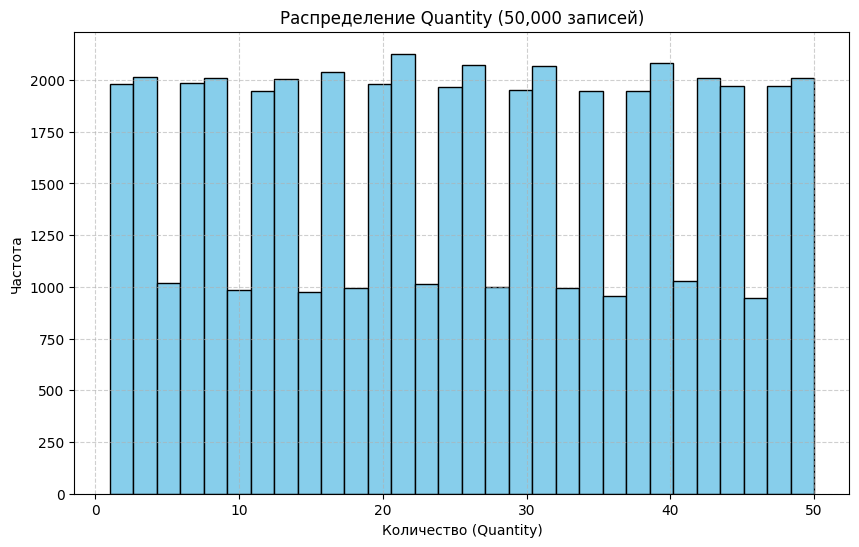


--- Вариант 8 Завершен ---
Соединение с базой данных закрыто


In [15]:
        # --- Задача 5: Python Визуализация ---
print("\n--- Задача 5: Визуализация quantity из sales_big ---")
sql_query_task5 = f"SELECT quantity FROM {big_table_name} LIMIT 50000;"
print(f"Получение данных для графика: {sql_query_task5}")

df_plot_data = load_df_from_sql(sql_query_task5)

if df_plot_data is not None and not df_plot_data.empty:
    print(f"Загружено {len(df_plot_data)} строк для построения графика.")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    # Построение гистограммы вместо scatter plot
    ax.hist(df_plot_data['quantity'], bins=30, color='skyblue', edgecolor='black')
    
    ax.set_xlabel('Количество (Quantity)')
    ax.set_ylabel('Частота') 
    ax.set_title('Распределение Quantity (50,000 записей)') 
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
elif df_plot_data is not None and df_plot_data.empty:
    print("Запрос выполнен, но данные из sales_big для графика не получены.")
else:
    print("Не удалось загрузить данные из sales_big для построения графика.")

print("\n--- Вариант 8 Завершен ---")



    # закрываем соединение 
if cursor:
        cursor.close()
if connection:
        connection.close()
print("Соединение с базой данных закрыто")


# --- Важно: Закройте соединение в конце вашего ноутбука ---
# print("\n--- Очистка ресурсов ---")
# close_db()